# 1. Setup

## 1.1 Install Dependencies

In [1]:
# pip install tensorflow=2.4.1 tensorflow-gpu=2.4.1 opencv-python matplotlib

## 1.2 Import Dependencies

In [2]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [3]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

2024-01-17 13:59:29.510112: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## 1.3 Set GPU growth

In [4]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-01-17 13:59:31.873196: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-17 13:59:31.874308: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2024-01-17 13:59:31.891288: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 13:59:31.891471: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84GiB/s
2024-01-17 13:59:31.891489: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2024-01-17 13:59:31.893287: I tensorflow/stream_executor/platform/de

## 1.4 Create Folder Structures

In [5]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [13]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

# 2. Collect Positives and Negatives

In [6]:
# Move LFW images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

## Collect positive and anchor classes

In [7]:
# Import uuid libraty to generate unique image names
import uuid

In [8]:
uuid.uuid1()

UUID('cd12b098-b559-11ee-a46c-b81ea46bcb35')

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]

    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)

    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)

    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()

# 3. Load and preprocess images

## Get image directories

In [10]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(300)

2024-01-17 13:59:57.492708: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-17 13:59:57.493302: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-01-17 13:59:57.493529: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-01-17 13:59:57.493751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 3.81GiB deviceMemoryBandwidth: 178.84G

In [11]:
dir_test = anchor.as_numpy_iterator()

In [12]:
dir_test.next()

b'data/anchor/c42acd1c-b0a9-11ee-bf1e-b81ea46bcb35.jpg'

## Preprocessing - Scale and resize

In [13]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)

    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))

    # Scale image to be between 0 and 1
    img = img / 255.0

    # Return image
    return img

In [14]:
img = preprocess('data/anchor/c361c908-b0a9-11ee-bf1e-b81ea46bcb35.jpg')

In [15]:
img.numpy().max()

0.7735294

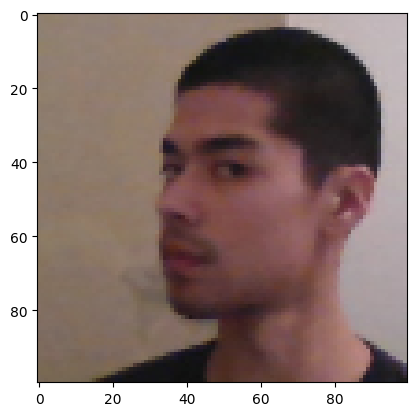

In [16]:
plt.imshow(img)

## Create labelled dataset

In [17]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [18]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [19]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [20]:
samples = data.as_numpy_iterator()

In [21]:
example = samples.next()

## Build train and test partition

In [22]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [23]:
res = preprocess_twin(*example)

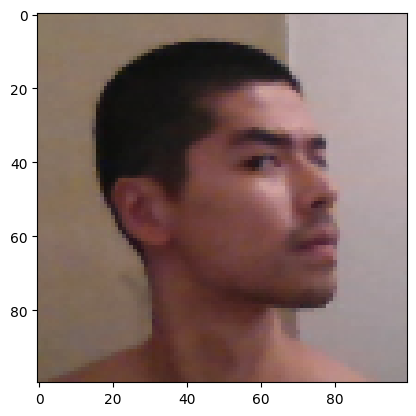

In [24]:
plt.imshow(res[0])

In [25]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [26]:
data

<ShuffleDataset shapes: ((100, 100, None), (100, 100, None), ()), types: (tf.float32, tf.float32, tf.float32)>

In [27]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [28]:
train_data

<PrefetchDataset shapes: ((None, 100, 100, None), (None, 100, 100, None), (None,)), types: (tf.float32, tf.float32, tf.float32)>

In [29]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model engineering

## Build embedding layer

In [30]:
inp = Input(shape=(100, 100, 3), name='input_image')

# First block
c1 = Conv2D(64, (10, 10), activation='relu')(inp)
m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

# Second block
c2 = Conv2D(128, (7, 7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

# Third block
c3 = Conv2D(128, (4, 4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

# Final embedding block
c4 = Conv2D(256, (4, 4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [31]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [32]:
def make_embedding():
    inp = Input(shape=(100, 100, 3), name='input_image')

    # First block
    c1 = Conv2D(64, (10, 10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2, 2), padding='same')(c1)

    # Second block
    c2 = Conv2D(128, (7, 7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2, 2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4, 4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4, 4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [33]:
embedding = make_embedding()

In [34]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

## Build distance layer

In [35]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **Kwargs):
        super().__init__()
    
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [36]:
l1 = L1Dist()

## Make Siamese model

In [37]:
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

In [38]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [39]:
siamese_layer = L1Dist()

In [40]:
distances = siamese_layer(inp_embedding, val_embedding)

In [41]:
classifier = Dense(1, activation='sigmoid')(distances)
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [42]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [43]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100, 100, 3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))

    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')


In [44]:
siamese_model = make_siamese_model()

In [45]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

# 5. Training

## Setup loss and optimizer

In [46]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [47]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

## Establish checkpoints

In [48]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## Build Train step function

In [49]:
test_batch = train_data.as_numpy_iterator()

In [50]:
batch_1 = test_batch.next()

2024-01-17 14:01:12.013565: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2024-01-17 14:01:12.020055: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3293850000 Hz


In [56]:
batch_1[2]

array([0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 0.],
      dtype=float32)

In [59]:
@tf.function
def train_step(batch):

    # Record all of our operations
    with tf.GradientTape() as tape:

        # Get anchor and positive/negative image
        X = batch[:2]

        # Get label
        y = batch[2]

        # Forward pass
        yhat = siamese_model(X, training=True)

        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weight and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))

    # Return loss
    return loss

In [61]:
def train(data, EPOCHS):

    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

    # Loop through each batch
    for idx, batch in enumerate(data):

        # Run train step here
        train_step(batch)
        progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

## Train the model

In [62]:
EPOCHS = 50

In [63]:
train(train_data, EPOCHS)


 Epoch 1/50

 Epoch 2/50

 Epoch 3/50

 Epoch 4/50

 Epoch 5/50

 Epoch 6/50

 Epoch 7/50

 Epoch 8/50

 Epoch 9/50

 Epoch 10/50

 Epoch 11/50

 Epoch 12/50

 Epoch 13/50

 Epoch 14/50

 Epoch 15/50

 Epoch 16/50

 Epoch 17/50

 Epoch 18/50

 Epoch 19/50

 Epoch 20/50

 Epoch 21/50

 Epoch 22/50

 Epoch 23/50

 Epoch 24/50

 Epoch 25/50

 Epoch 26/50

 Epoch 27/50

 Epoch 28/50

 Epoch 29/50

 Epoch 30/50

 Epoch 31/50

 Epoch 32/50

 Epoch 33/50

 Epoch 34/50

 Epoch 35/50

 Epoch 36/50

 Epoch 37/50

 Epoch 38/50

 Epoch 39/50

 Epoch 40/50

 Epoch 41/50

 Epoch 42/50

 Epoch 43/50

 Epoch 44/50

 Epoch 45/50

 Epoch 46/50

 Epoch 47/50

 Epoch 48/50

 Epoch 49/50

 Epoch 50/50
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please re

2024-01-17 14:19:15.809292: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2024-01-17 14:19:16.142095: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2024-01-17 14:19:17.401025: W tensorflow/stream_executor/gpu/asm_compiler.cc:63] Running ptxas --version returned 256
2024-01-17 14:19:17.477914: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Internal: ptxas exited with non-zero error code 256, output: 
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


27/27 [==============================] - 57s 2s/step


# 6. Evaluate model

In [64]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [97]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [98]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])
y_hat

array([[0.0281511 ],
       [0.01643316],
       [0.10233194],
       [0.9733372 ],
       [0.6801136 ],
       [0.00145793],
       [0.6973187 ],
       [0.1469945 ],
       [0.95786893],
       [0.07875606],
       [0.01071674],
       [0.72851384],
       [0.01773644],
       [0.03469309],
       [0.9170689 ],
       [0.64189297]], dtype=float32)

In [99]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]

In [100]:
y_true

array([0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 1.],
      dtype=float32)

In [101]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true, y_hat)

# Return Recall result
m.result().numpy()

1.0

# 7. Save model